## In questo notebook filtro i pattern interessanti tra tutti quelli ottenuti, salvo i risultati del filtro e i plot "supporto-confidenza" per ogni file in input

In [1]:
#IMPORTS
from pyspark.sql import Row
import pyspark.sql.functions as F
import numpy as np
import sys
import matplotlib.pyplot as plt
import operator
import ast
from pathlib import Path


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [6]:
#THRESHOLD per il filtering
conf_threshold = 0.40
sup_threshold = 0

#Flag usati per il flitraggio
filter_normal = False    #flag utile ad eliminare tutti i parten che contenessero lo stato "Normal"

time_slots_flag = True
time_slots = ["0-6", "6-10", "10-14", "14-17", "17-20", "20-24"]

#Parametri usati nell'estrazione dei pattern
time_interval = 30
space_interval = 1000

In [8]:
inputPaths = {}
outputPaths = {}

if time_slots_flag:
    for i, slot in enumerate(time_slots):
        inputPaths[f"inputPath{i}"] = f"file:///home/bigdata-01QYD/s270240/bike_sharing/Associative_classifier/Results_extraction/{time_interval}min_{space_interval}m/Time_slots/results_{slot}_StateChange_Normal_almostFull_{time_interval}_{space_interval}_0(3-3)_ordered_by_confidence.txt"
        if filter_normal:
            outputPaths[f"outputPath{i}"] = f"./Results_extraction/{time_interval}min_{space_interval}m/Time_slots/filtered_results_{slot}_({int(conf_threshold*100)}%-{sup_threshold})_StateChange_almostFull_{time_interval}_{space_interval}_0(3-3)_ordered_by_confidence.txt"    
        else:
            outputPaths[f"outputPath{i}"] = f"./Results_extraction/{time_interval}min_{space_interval}m/Time_slots/filtered_results_{slot}_({int(conf_threshold*100)}%-{sup_threshold})_StateChange_Normal_almostFull_{time_interval}_{space_interval}_0(3-3)_ordered_by_confidence.txt"

else:
    inputPaths[f"inputPath0"] = f"file:///home/bigdata-01QYD/s270240/bike_sharing/Associative_classifier/Results_extraction/{time_interval}min_{space_interval}m/results_StateChange_Normal_almostFull_{time_interval}_{space_interval}_0(3-3)_ordered_by_confidence.txt"

    if filter_normal:
        outputPaths[f"outputPath0"] = f"./Results_extraction/{time_interval}min_{space_interval}m/filtered_results({int(conf_threshold*100)}%-{sup_threshold})_StateChange_almostFull_{time_interval}_{space_interval}_0(3-3)_ordered_by_confidence.txt"    
    else:
        outputPaths[f"outputPath0"] = f"./Results_extraction/{time_interval}min_{space_interval}m/filtered_results({int(conf_threshold*100)}%-{sup_threshold})_StateChange_Normal_almostFull_{time_interval}_{space_interval}_0(3-3)_ordered_by_confidence.txt"



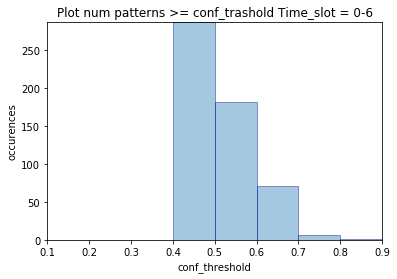

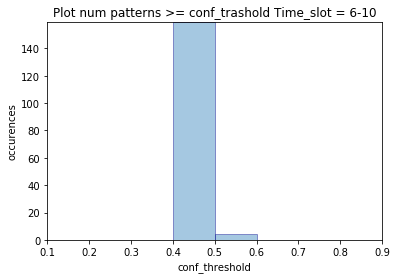

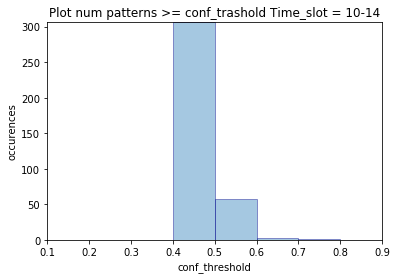

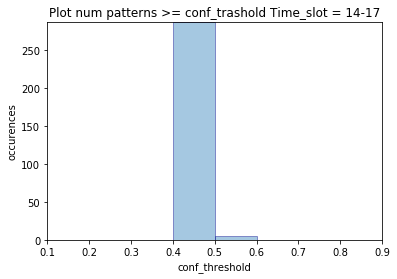

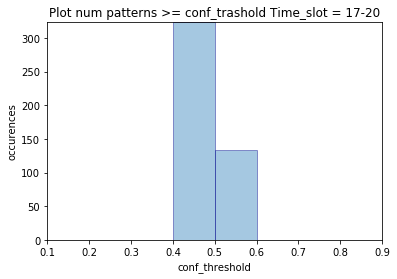

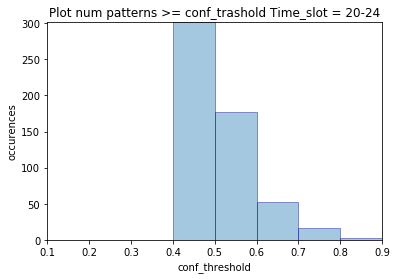

In [9]:

for i in range (0, len(inputPaths)):

    #read file
    patterns = sc.textFile(inputPaths[f"inputPath{i}"])

    #remove file headers 
    patterns = patterns.zipWithIndex().filter(lambda kv: kv[1] > 1).keys()

    #filter patterns containing in the last element only elements with "_0" and "QuasiPiena"
    def filtering(line):
        s_list = ast.literal_eval(line)
        last = s_list[0][0][-1]
        list_of_last = last[0].split(',')
        for el in list_of_last:
            if "_0" not in el or "QuasiPiena" not in el:
                return False
        return True

    filtered_patterns = patterns.filter(filtering)

    def conf_sup_filtering(line):
        s_list = ast.literal_eval(line)
        conf_sup = s_list[1][0]
        conf = float(conf_sup.split(' - ')[0])
        sup = int(conf_sup.split(' - ')[1])
        if conf >= conf_threshold and sup>=sup_threshold:
            return True
        else:
            return False

    filtered_patterns = filtered_patterns.filter(conf_sup_filtering)

    def filter_Normal(line):
        s_list = ast.literal_eval(line)
        for el in s_list[0][0]:
            if "Normal" in el[0]:
                return False
        return True

    if filter_normal:
        filtered_patterns = filtered_patterns.filter(filter_Normal)

    #save filtered_patterns
    file = open(outputPaths[f"outputPath{i}"], "w") 
    file.write('Filtered Pattern, Confidence-Frequence'+'\n')
    file.write(f'Total number of input patterns: {filtered_patterns.count()}'+'\n')
    for el in filtered_patterns.collect():  
        file.write(str(el)+ '\n')   
    file.close()


    #extract confidences list
    def extract_confidences(line):
        s_list = ast.literal_eval(line)
        confidence = s_list[1][0].split(' - ')[0]
        return float(confidence)

    confidences_list = filtered_patterns.map(extract_confidences).collect()

    #extract suppprts list
    def extract_supports(line):
        s_list = ast.literal_eval(line)
        support = s_list[1][0].split(' - ')[1]
        return int(support)

    supports_list = filtered_patterns.map(extract_supports).collect()

#     save support-confidence plot
    if time_slots_flag:
        title = f'Plot img_support_confidence Time_slot = {time_slots[i]}'
    else:
        title = 'Plot img_support_confidence'
    plt.scatter(supports_list, confidences_list)
    plt.xlabel('support') 
    plt.ylabel('confidence')
    _=plt.title(title)
    plt.savefig(imgs_support_confidence[f"img_support_confidence{i}"]) #img_support_confidence-i
    plt.show()

    
    #save plot of number of pattern with certaion confidence
    if time_slots_flag:
        plt.title( f'Plot img_confidence Time_slot = {time_slots[i]}')
    else:
        plt.title( 'Plot img_confidence')
    plt.hist(confidences_list)
    plt.xlabel('Confidence')
    plt.ylabel('Number of patterns')
    plt.xlim(0.3,1)
    plt.savefig(imgs_confidence[f"img_confidence{i}"]) #img_confidence-i
    plt.show()
    
    
#     plot number of pattern >= conf_trashold    
    conf_trhesholds = [0.40,0.50,0.60,0.70,0.80,0.90,0.100]
    bincenters = (np.array(conf_trhesholds)[1:] + conf_trhesholds[:-1])/2
    binwidths = np.diff(conf_trhesholds)
    binvals = [np.sum(np.array(confidences_list)>=thresh) for thresh in conf_trhesholds[:-1]]
    fig, ax = plt.subplots()
    if time_slots_flag:
        plt.title( f'Plot num patterns >= conf_trashold Time_slot = {time_slots[i]}')
    else:
        plt.title( f'Plot num patterns >= conf_trashold')
    ax.bar(bincenters, binvals, width=binwidths, alpha=0.4,
           edgecolor=['darkblue'])
    ax.set_xlabel('conf_threshold')
    ax.set_ylabel('occurences')
    ax.autoscale('x', tight=True)
    plt.show()